In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip


In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip


In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip

In [ ]:
import os
import zipfile
from tensorflow.keras.utils import get_file

def download_and_extract_dataset():
  # dataset from https://github.com/udacity/dermatologist-ai
  # 5.3GB
  train_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip"
  # 824.5MB
  valid_url = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip"
  # 5.1GB
  test_url  = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip"
  for i, download_link in enumerate([valid_url, train_url, test_url]):
    temp_file = f"temp{i}.zip"
    data_dir = get_file(origin=download_link, fname=os.path.join(os.getcwd(), temp_file))
    print("Extracting", download_link)
    with zipfile.ZipFile(data_dir, "r") as z:
      z.extractall("data")
    # remove the temp file
    os.remove(temp_file)

# comment the below line if you already downloaded the dataset
download_and_extract_dataset()

864538487/864538487 [==============================] - 13s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
5736557430/5736557430 [==============================] - 80s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
5528640507/5528640507 [==============================] - 78s 0us/step
Extracting https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip


In [5]:
import tensorflow as tf
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# tf.config.experimental.set_virtual_device_configuration(
#     physical_devices[0],
#     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1250*3)])
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path



In [ ]:
!unzip train.zip

In [ ]:
!unzip test.zip

In [ ]:
!unzip valid.zip

In [ ]:
import glob
import pandas as pd

def generate_csv(folder, label2int):
    folder_name = os.path.basename(folder)
    labels = list(label2int)
    # generate CSV file
    df = pd.DataFrame(columns=["filepath", "label"])
    i = 0
    for label in labels:
        print("Reading", os.path.join(folder, label, "*"))
        for filepath in glob.glob(os.path.join(folder, label, "*")):
            df.loc[i] = [filepath, label2int[label]]
            i += 1
    output_file = f"{folder_name}.csv"
    print("Saving", output_file)
    df.to_csv(output_file)

generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

Reading data/train/nevus/*
Reading data/train/seborrheic_keratosis/*
Reading data/train/melanoma/*
Saving train.csv
Reading data/valid/nevus/*
Reading data/valid/seborrheic_keratosis/*
Reading data/valid/melanoma/*
Saving valid.csv
Reading data/test/nevus/*
Reading data/test/seborrheic_keratosis/*
Reading data/test/melanoma/*
Saving test.csv


In [ ]:
# Set random seeds consistently
tf.random.set_seed(7)
np.random.seed(7)

# 0 for benign, 1 for malignant
class_names = ["benign", "malignant"]

def generate_csv(folder, label2int):
    folder_name = Path(folder).name
    labels = list(label2int.keys())
    data_list = []

    for label in labels:
        filepaths = list(Path(folder, label).glob("*"))
        label_int = label2int[label]
        data = [{"filepath": str(filepath), "label": str(label_int)} for filepath in filepaths]
        data_list.extend(data)

    df = pd.DataFrame(data_list)
    output_file = f"{folder_name}.csv"
    df.to_csv(output_file, index=False)
    print(f"Saved {output_file}")

# Generate CSV files
generate_csv("data/train", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/valid", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})
generate_csv("data/test", {"nevus": 0, "seborrheic_keratosis": 0, "melanoma": 1})

# Load and preprocess images using data generators
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)



# Data Augmentation for Training Images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data Augmentation for Validation Images
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

batch_size = 64

# Convert label column values to strings
df_train['label'] = df_train['label'].astype(str)
df_valid['label'] = df_valid['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col="filepath",
    y_col="label",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True,
    seed=7
)

valid_generator = valid_datagen.flow_from_dataframe(
    df_valid,
    x_col="filepath",
    y_col="label",
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)



Saved train.csv
Saved valid.csv
Saved test.csv
Number of training samples: 2000
Number of validation samples: 150
Found 2000 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=n_training_samples // batch_size,
    validation_data=valid_generator,
    validation_steps=n_validation_samples // batch_size,
    verbose=1,
    epochs=15
)

# Save the model
model.save("skin_condition_classifier_cnn4.h5")

tf.keras.models.save_model(model, 'saved_model_directory6')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
tf.keras.models.save_model(model, 'saved_model_directory4')

In [1]:
import numpy as np
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

# Load the saved model for prediction
loaded_model = load_model('skin_condition_classifier_cnn4.h5')
#loaded_model = model
print(loaded_model.summary())
#loaded_model = model
# Load an image for prediction (replace 'path_to_image.jpg' with the actual image path)
#img_path = 'ISIC_2019_Training_Input/ISIC_0000002.jpg'
img_path = 'test1.jpg'  ##Image name. Set it to filename of the image you want to check
img = Image.open(img_path)
img = img.resize((299, 299))  # Resize the image to match the model's input size

# Convert the image to a numpy array
img_array = np.array(img)
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
prediction = loaded_model.predict(img_array)
print(prediction)
# Convert the prediction to a class label
if prediction[0][0] >= 0.4:
    print("Malignant")
else:
    print("Benign")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [2]:
model = loaded_model

In [3]:
def predict_image_class(img_path, model, threshold=0.5):
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.expand_dims(img, 0) # Create a batch
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.image.convert_image_dtype(img, tf.float32)
  predictions = model.predict(img)
  score = predictions.squeeze()
  if score >= threshold:
    print(f"This image is {100 * score:.2f}% malignant.")
  else:
    print(f"This image is {100 * (1 - score):.2f}% benign.")
  plt.imshow(img[0])
  plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 67ms/step


This image is 88.39% malignant.


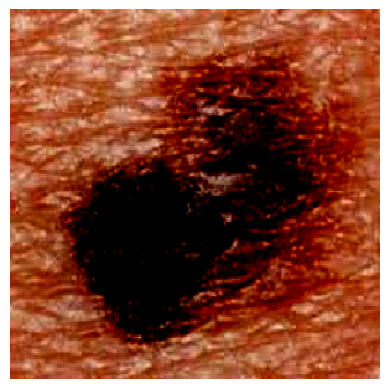

In [6]:
predict_image_class("test5mal.jpeg", model)

In [7]:
# loading data
train_metadata_filename = "train.csv"
valid_metadata_filename = "valid.csv"
# load CSV files as DataFrames
df_train = pd.read_csv(train_metadata_filename)
df_valid = pd.read_csv(valid_metadata_filename)
n_training_samples = len(df_train)
n_validation_samples = len(df_valid)
print("Number of training samples:", n_training_samples)
print("Number of validation samples:", n_validation_samples)
train_ds = tf.data.Dataset.from_tensor_slices((df_train["filepath"], df_train["label"]))
valid_ds = tf.data.Dataset.from_tensor_slices((df_valid["filepath"], df_valid["label"]))

Number of training samples: 2000
Number of validation samples: 150


In [8]:
# preprocess data
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [299, 299])


def process_path(filepath, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(filepath)
  img = decode_img(img)
  return img, label


valid_ds = valid_ds.map(process_path)
train_ds = train_ds.map(process_path)
# test_ds = test_ds
for image, label in train_ds.take(1):
    print("Image shape:", image.shape)
    print("Label:", label.numpy())

Image shape: (299, 299, 3)
Label: 0


In [9]:
# training parameters
batch_size = 64
optimizer = "rmsprop"

def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

valid_ds = prepare_for_training(valid_ds, batch_size=batch_size, cache="valid-cached-data")
train_ds = prepare_for_training(train_ds, batch_size=batch_size, cache="train-cached-data")

In [10]:
# evaluation
# load testing set
test_metadata_filename = "test.csv"
df_test = pd.read_csv(test_metadata_filename)
n_testing_samples = len(df_test)
print("Number of testing samples:", n_testing_samples)
test_ds = tf.data.Dataset.from_tensor_slices((df_test["filepath"], df_test["label"]))

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  return ds

test_ds = test_ds.map(process_path)
test_ds = prepare_for_testing(test_ds, cache="test-cached-data")

Number of testing samples: 600


In [11]:
# convert testing set to numpy array to fit in memory (don't do that when testing
# set is too large)
y_test = np.zeros((n_testing_samples,))
X_test = np.zeros((n_testing_samples, 299, 299, 3))
for i, (img, label) in enumerate(test_ds.take(n_testing_samples)):
  # print(img.shape, label.shape)
  X_test[i] = img
  y_test[i] = label.numpy()

print("y_test.shape:", y_test.shape)

y_test.shape: (600,)


In [13]:
print("Evaluating the model...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Loss:", loss, "  Accuracy:", accuracy)

Evaluating the model...
Loss: 0.4926281273365021   Accuracy: 0.800000011920929
